<a href="https://colab.research.google.com/github/tompc35/oceanography-notebooks/blob/master/plot_line_p_profiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CTD casts from Line P

This IPython notebook plots CTD casts from historical stations along Canada's Line P in the North Pacific ocean. 

![Line P map](https://www.dfo-mpo.gc.ca/science/images/data-donnees/line-p/Line_Psmall.gif)

Historical background on Line P can be found at:
https://www.dfo-mpo.gc.ca/science/data-donnees/line-p/index-eng.html

This notebook uses bottle (.che) files obtained at:
https://www.dfo-mpo.gc.ca/science/data-donnees/line-p/data-eng.html

The input file name may be changed to plot profiles from different cruises and/or stations. You do not need to download any data for these exercises.

Written by Tom Connolly (tconnolly@mlml.calstate.edu) 
for MS142 (Physical Oceanography)

In [1]:
!pip install gsw  # Install Gibbs Seawater toolbox (GSW)
!git clone https://github.com/tompc35/ms142-line-p-data.git  # Download data
  
# Import libraries
import gsw as gsw
import numpy as np
from re import sub
from matplotlib import pyplot as plt

fatal: destination path 'ms142-line-p-data' already exists and is not an empty directory.


Show the available files. Each .che file contains data from a different profile along Line P.



In [2]:
!ls ms142-line-p-data

1999-01-0005.che  2006-08-0026.che  2006-08-0054.che  2006-15-0007.che
1999-01-0017.che  2006-08-0052.che  2006-15-0005.che  2006-15-0060.che


## Specify file here

Choose a different file by changing the file name in quotes.

In [3]:
filename = "2006-08-0026.che"

Parse the file and load the data into variables.

*There should be no need to edit this section!*


In [4]:
f = open('ms142-line-p-data/'+filename, 'r',errors='ignore')

readdata = False
firstline = True
for line in f.readlines():
    if readdata==True:
        line = sub("[a-z]", ' ', line) # strip flag characters
        d = np.fromstring(line,sep=" ")
        if firstline == True:
            data = d
            firstline = False
        else:
            data = np.vstack((data,d))
    if line.startswith("*END OF HEADER")==True:
        readdata=True          
    # get station position from header
    if "LATITUDE" in line:
        starti = line.index(":")+1
        endi = line.index("N")-1
        degmin = np.fromstring(line[starti:endi],sep=" ")
        lat = degmin[0]+degmin[1]/60
    if "LONGITUDE" in line:
        starti = line.index(":")+1
        endi = line.index("W")-1
        degmin = np.fromstring(line[starti:endi],sep=" ")
        lon = -degmin[0]-degmin[1]/60
    if "STATION" in line:
        starti = line.index(":")+1
        station_name = line[starti:-2]
    if "START TIME" in line:    
        starti = line.index("C")+1 
        endi = line.index(".") 
        date_string = line[starti:endi]
    
f.close()
      
ncol = data.shape[1]    
    
p = data[:,0]   # pressure [dbar]
T = data[:,1]   # temperature [deg C]
Sp = data[:,2]  # practical salinity
if ncol >= 4:
    O2 = data[:,3]
if ncol >= 5:
    nitrate = data[:,4]
if ncol >= 6:
    phosphate = data[:,5]
if ncol >= 7:
    silicate = data[:,6]

Use the GSW toolbox to compute absolute salinity, potential temperature and conservative temperature.

In [5]:
SA = gsw.SA_from_SP(Sp,p,lon,lat)
Tpot = gsw.pt_from_t(SA, T, p, 0)
CT = gsw.CT_from_t(SA,T,p)
sigma0 = gsw.sigma0(SA, CT)
rho = gsw.rho(SA,CT,p)

# Plots

## Temperature $T$, potential temperature $\theta$, and conservative temperature $\Theta$

Text(0.5, 1.0, '48.650N -126.667W  2006/02/06 02:22:23')

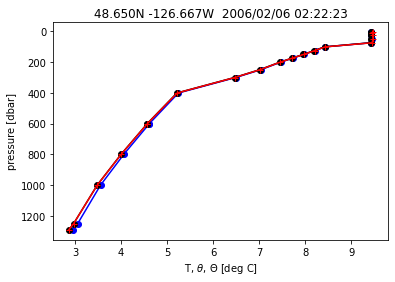

In [6]:
plt.plot(T,p,'b-o')
plt.plot(Tpot,p,'k-o')
plt.plot(CT,p,'r-+')
plt.gca().invert_yaxis()
plt.xlabel('T, $\\theta$, $\Theta$ [deg C]')
plt.ylabel('pressure [dbar]')
plt.title(str(lat)[:6] + 'N ' + str(lon)[:8] + 'W ' + date_string)

## Practical salinity $S_P$ and absolute salinity $S_A$

Text(0.5, 1.0, '48.650N -126.667W  2006/02/06 02:22:23')

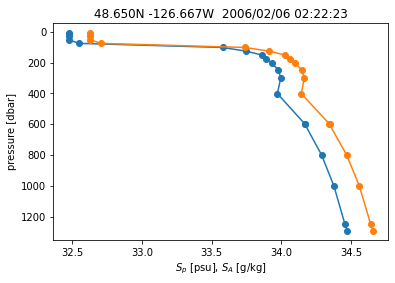

In [7]:
plt.plot(Sp,p,'-o')
plt.plot(SA,p,'-o')
plt.gca().invert_yaxis()
plt.xlabel('$S_p$ [psu], $S_A$ [g/kg]')
plt.ylabel('pressure [dbar]')
plt.title(str(lat)[:6] + 'N ' + str(lon)[:8] + 'W ' + date_string)

Text(0.5, 1.0, '48.650N -126.667W  2006/02/06 02:22:23')

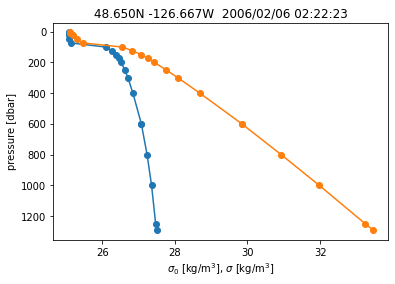

In [8]:
plt.plot(sigma0,p,'-o')
plt.plot(rho-1000,p,'-o')
plt.gca().invert_yaxis()
plt.xlabel('$\sigma_0$ [kg/m$^3$], $\sigma$ [kg/m$^3$]')
plt.ylabel('pressure [dbar]')
plt.title(str(lat)[:6] + 'N ' + str(lon)[:8] + 'W ' + date_string)

## Density anomaly $\sigma$ and potential density anomaly $\sigma_0$

## Dissolved oxygen

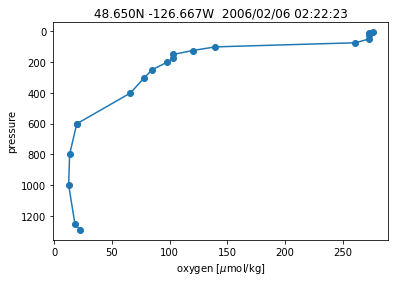

In [9]:
if ncol >= 4:
    plt.plot(O2,p,'-o')
    plt.gca().invert_yaxis()
    plt.xlabel('oxygen [$\mu$mol/kg]')
    plt.ylabel('pressure')
    plt.title(str(lat)[:6] + 'N ' + str(lon)[:8] + 'W ' + date_string)

## Oxygen vs. NO$^-_3$+NO$^-_2$

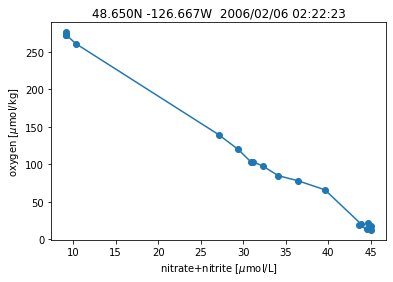

In [10]:
if ncol >= 5:
    plt.plot(nitrate,O2,'-o')
    plt.xlabel('nitrate+nitrite [$\mu$mol/L]')
    plt.ylabel('oxygen [$\mu$mol/kg]')
    plt.title(str(lat)[:6] + 'N ' + str(lon)[:8] + 'W ' + date_string)

## $\Theta$-$S$ diagram

Contours denote potential density $\sigma_0$

<a list of 9 text.Text objects>

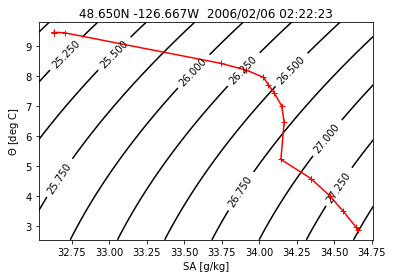

In [11]:
plt.plot(SA,CT,'r-+')
plt.ylabel('$\Theta$ [deg C]')
plt.xlabel('SA [g/kg]')
plt.title(str(lat)[:6] + 'N ' + str(lon)[:8] + 'W ' + date_string)
SA_lim = plt.xlim()
CT_lim = plt.ylim()
SA_arr,CT_arr = np.meshgrid(np.linspace(SA_lim[0],SA_lim[1]),np.linspace(CT_lim[0],CT_lim[1]))
sigma_arr = gsw.sigma0(SA_arr,CT_arr)
c = plt.contour(SA_arr,CT_arr,sigma_arr,np.arange(20,30,0.25),colors='k')
plt.clabel(c)